### Transport algorithm to calculate upwelled water (and tracer) 

Define shelf boundary and calculate volume of water transported onto the shelf through cells with $C_i \ge C_s$

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [83]:
def plotCSPos(ax,CS1,CS2,CS3,CS4,CS5,CS6):
    ax.axvline(CS1,color='k',linestyle=':')
    ax.axvline(CS2,color='k',linestyle=':')
    ax.axvline(CS3,color='k',linestyle=':')
    ax.axvline(CS4,color='k',linestyle=':')
    ax.axvline(CS5,color='k',linestyle=':')
    ax.axvline(CS6,color='k',linestyle=':')
 
def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

In [3]:
sns.set_context('notebook')
sns.set_style('white')

In [108]:
Grid = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc' 
with Dataset(Grid, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    Y = nbl.variables['Y'][:]
    X = nbl.variables['X'][:]
    hFac = nbl.variables['HFacC'][:]
    Depth = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFac, 0)
    maskC = np.ma.getmask(hfac)
    rA = nbl.variables['rA'][:]
    dxg = nbl.variables['dxG'][:]
    drf = nbl.variables['drF'][:]
    
GridNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc' 
with Dataset(GridNoC, 'r') as nbl:
    Znoc = nbl.variables['RC'][:]
    Ynoc = nbl.variables['Y'][:]
    Xnoc = nbl.variables['X'][:]
    hFacnoc = nbl.variables['HFacC'][:]
    Depthnoc = nbl.variables['Depth'][:]
    hfacnoc = np.ma.masked_values(hFacnoc, 0)
    maskCnoc = np.ma.getmask(hfacnoc)
    rAv = nbl.variables['rA'][:]

State = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc' 
StateNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/stateGlob.nc' 
st = xr.open_dataset(State)

Ptracer = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc' 
ptr = xr.open_dataset(Ptracer)


In [5]:
t_slice = slice(10,20)
x_slice = slice(0,616)
x_slice_vert = slice(120,240)
y_slice_vert = slice(130,230)
z_slice = slice(0,80)
z_slice_zoom = slice(0,40)
y_ind = 130 # sb index
z_ind = 39 # sb index

Tracer 01 concentration at day 8.0 at shelf break cross-section and shelf-break depth horizontal section.
 Masked values have C<C_s=9.2 uM


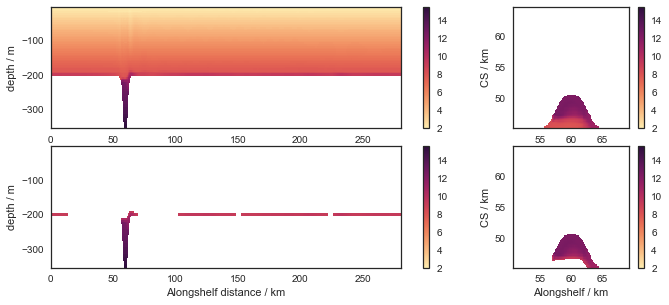

In [82]:
tt = 16
bgcolor = '#8b7765'

f = plt.figure(figsize = (11,4.8))
gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace = 0.0)
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.1,height_ratios=[1,1])
gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1],hspace=0.15,wspace=0.1,height_ratios=[1,1])

ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

#ax1.set_facecolor(bgcolor)
#ax2.set_facecolor(bgcolor)
#ax3.set_facecolor(bgcolor)
#ax0.set_facecolor(bgcolor)

Cs = ptr.Tr01[0,z_ind,50,180]
Cmax = ptr.Tr01[0,62,50,180]
Cmin = ptr.Tr01[0,0,50,180]

Tr_masked = np.ma.masked_array(ptr.Tr01[tt,:62,y_ind,:],mask=maskC[:62, y_ind,:])

pc0 = ax0.pcolormesh(X/1000,Z[:62],Tr_masked, cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
pc1 = ax1.pcolormesh(X/1000,Z[:62],np.ma.masked_less(Tr_masked, Cs), 
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc0, ax=ax0)
plt.colorbar(pc1, ax=ax1)
ax0.set_ylabel('depth / m')
ax1.set_ylabel('depth / m')
ax1.set_xlabel('Alongshelf distance / km')

Tr_masked_v = np.ma.masked_array(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert],mask=maskC[z_ind,y_slice_vert, x_slice_vert])

pc2 = ax2.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
                     Tr_masked_v,
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc2, ax=ax2)
pc3 = ax3.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
                     np.ma.masked_less(Tr_masked_v, Cs), 
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc3, ax=ax3)

mask_cs = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,:62,y_ind,:], Cs))
mask_vert = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert], Cs))

ax3.set_xlabel('Alongshelf / km')
ax2.set_ylabel('CS / km')
ax3.set_ylabel('CS / km')

ax2.set_aspect(1)
ax3.set_aspect(1)

print('Tracer 01 concentration at day %1.1f at shelf break cross-section and shelf-break depth horizontal section.\n Masked values have C<C_s=%1.1f uM' %(tt/2, Cs))

V, W at day 8.0 at shelf break cross-section and shelf-break depth horizontal section. 
 Masked values have C<C_s=9.2 uM


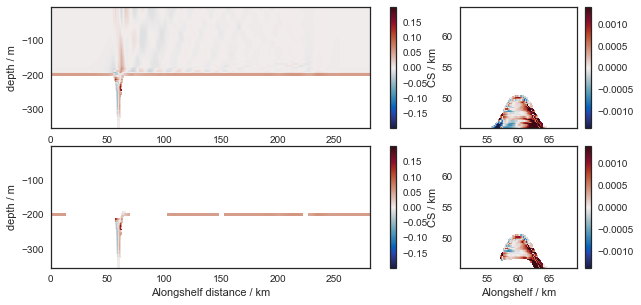

In [95]:
tt = 16
f = plt.figure(figsize = (10,4.8))
gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0)
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.15,height_ratios=[1,1])
gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1],hspace=0.15,wspace=0.15,height_ratios=[1,1])

ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

Vmax = np.max(st.V[10,:,:,:])
Vmin = -Vmax #np.min(st.V[10,:,:,:])
Wmax = np.max(st.W[10,62,:,:])
Wmin = -Wmax#np.min(st.W[10,:,:,:])

V = st.V.isel(T = tt,Z=slice(0,62))
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_masked = np.ma.masked_array(V[:,y_ind,:],mask=maskC[:62, y_ind,:])

pc0 = ax0.pcolormesh(X/1000,Z[:62],V_masked, cmap=cmo.cm.balance, vmax=Vmax, vmin = Vmin)
pc1 = ax1.pcolormesh(X/1000,Z[:62],np.ma.masked_array(V_masked, mask = mask_cs),
               cmap=cmo.cm.balance, vmax=Vmax, vmin = Vmin)
plt.colorbar(pc0, ax=ax0)
plt.colorbar(pc1, ax=ax1)
ax0.set_ylabel('depth / m')
ax1.set_ylabel('depth / m')
ax1.set_xlabel('Alongshelf distance / km')

W_masked = np.ma.masked_array(st.W[tt,z_ind,y_slice_vert,x_slice_vert],mask=maskC[z_ind, y_slice_vert, x_slice_vert])

pc2 = ax2.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,W_masked,
               cmap=cmo.cm.balance, vmax = Wmax, vmin = Wmin)
pc3 = ax3.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
               np.ma.masked_array(W_masked, mask=mask_vert), 
               cmap=cmo.cm.balance, vmax = Wmax, vmin = Wmin)
plt.colorbar(pc2, ax=ax2)
plt.colorbar(pc3, ax=ax3)
ax3.set_xlabel('Alongshelf / km')
ax2.set_ylabel('CS / km')
ax3.set_ylabel('CS / km')

ax2.set_aspect(1)
ax3.set_aspect(1)

print('V, W at day %1.1f at shelf break cross-section and shelf-break depth horizontal section. \n Masked values have C<C_s=%1.1f uM' %(tt/2, Cs))

**Algorithm**

In [114]:
y_ind = 130
z_ind = 39
x_st = 180
y_st = 50

Cs = ptr.Tr01[0,z_ind,y_st,x_st]
tt = slice(0,2)


# Mask using Cs criterion 
mask_exp = mpt.maskExpand(maskC,ptr.Tr01[tt,:,:,:])
Tr_masked = np.ma.masked_array(ptr.Tr01[tt,:,y_ind,:],mask=mask_exp[tt,:,y_ind,:])
Tr_masked_v = np.ma.masked_array(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert],
                                 mask=mask_exp[tt,z_ind,y_slice_vert, x_slice_vert])
# Get tracer mask
mask_cs = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,:,y_ind,:], Cs))
mask_vert = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert], Cs))

# Get V and unstagger
V = st.V.isel(T = tt)
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_masked = np.ma.masked_array(V[tt,:,y_ind,:],mask=mask_exp[tt,:, y_ind,:])

# Apply tracer mask to unstaggered V
V_upw = np.ma.masked_array(V_masked, mask = mask_cs)

# Calculate transport
V_upw = np.ma.masked_array(V_masked, mask = mask_cs)



# Apply land mask to W 
W_masked = np.ma.masked_array(st.W[tt,z_ind,y_slice_vert,x_slice_vert],
                              mask=mask_exp[tt,z_ind,y_slice_vert,x_slice_vert])

# Apply tracer mask to land-masked W
W_upw = np.ma.masked_array(W_masked, mask=mask_vert)

ValueError: operands could not be broadcast together with shapes (616,) (104,) 

In [113]:
np.shape(dxg)

(361, 616)